<a href="https://colab.research.google.com/github/TejasreeL/EmoWave/blob/main/RavdessDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import tensorflow as tf
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

##Loading Ravdess Dataset

In [2]:
os.listdir()

['.config', 'drive', 'sample_data']

In [3]:
os.chdir('drive')

In [4]:
os.listdir()

['.file-revisions-by-id', 'MyDrive', '.shortcut-targets-by-id', '.Trash-0']

In [5]:
os.chdir('MyDrive')

In [6]:
os.listdir()

['2nd Year 2022 Pre-Final Question Papers',
 'SRMJEEE',
 'FIITJEE 2022',
 'TEJASREE',
 'Novels',
 'Riddle bee',
 'IMG-20221219-WA0001 (2).jpg',
 'IMG-20221219-WA0001 (1).jpg',
 'photos ',
 'HP files',
 'w.txt',
 'IMG-20230201-WA0013.jpg',
 'Screenshot_2023-02-01-18-03-50-73 (1).png',
 'Screenshot_2023-02-01-18-03-50-73.png',
 'Screenshot_2023-02-01-18-06-29-39.png',
 'HP Files New',
 'Colab Notebooks',
 'IMG-20221219-WA0001.jpg',
 'Ravdess']

In [7]:
os.chdir('Ravdess')

In [8]:
os.listdir()

['03-01-05-02-02-02-08.wav',
 '03-01-08-02-01-02-07.wav',
 '03-01-07-01-02-01-07.wav',
 '03-01-07-01-02-02-07.wav',
 '03-01-03-01-02-01-08.wav',
 '03-01-04-01-02-01-08.wav',
 '03-01-05-01-02-02-08.wav',
 '03-01-05-01-01-01-08.wav',
 '03-01-06-01-01-01-08.wav',
 '03-01-02-01-01-02-08.wav',
 '03-01-05-01-02-01-08.wav',
 '03-01-02-02-02-02-08.wav',
 '03-01-01-01-01-02-08.wav',
 '03-01-04-01-01-01-08.wav',
 '03-01-04-02-01-01-08.wav',
 '03-01-02-02-02-01-08.wav',
 '03-01-04-02-02-01-08.wav',
 '03-01-05-02-02-01-08.wav',
 '03-01-08-01-02-02-08.wav',
 '03-01-08-01-02-01-08.wav',
 '03-01-07-01-01-01-08.wav',
 '03-01-05-01-01-01-09.wav',
 '03-01-07-02-01-01-08.wav',
 '03-01-04-02-01-02-09.wav',
 '03-01-04-01-01-01-09.wav',
 '03-01-06-02-01-01-08.wav',
 '03-01-03-01-02-02-09.wav',
 '03-01-03-01-01-02-09.wav',
 '03-01-03-02-01-02-09.wav',
 '03-01-05-01-02-02-09.wav',
 '03-01-02-02-02-01-09.wav',
 '03-01-06-02-01-02-08.wav',
 '03-01-05-01-02-01-09.wav',
 '03-01-01-01-02-01-09.wav',
 '03-01-03-02-

In [9]:
ravdess_directory = os.listdir()

In [10]:
file_emotion, file_path = [], []
for audio in os.listdir():
    part = audio.split('.')[0]
    part = part.split('-')
    # third part in each file represents the emotion associated to that file.
    file_emotion.append(int(part[2]))
    file_path.append(audio)
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df

Emotions                      Path
0        angry  03-01-05-02-02-02-08.wav
1     surprise  03-01-08-02-01-02-07.wav
2      disgust  03-01-07-01-02-01-07.wav
3      disgust  03-01-07-01-02-02-07.wav
4        happy  03-01-03-01-02-01-08.wav
...        ...                       ...
1435       sad  03-01-04-02-01-02-08.wav
1436   neutral  03-01-01-01-01-01-08.wav
1437     happy  03-01-03-02-01-01-08.wav
1438     angry  03-01-05-01-01-02-08.wav
1439  surprise  03-01-08-02-02-01-07.wav

[1440 rows x 2 columns]

##Data Analysis

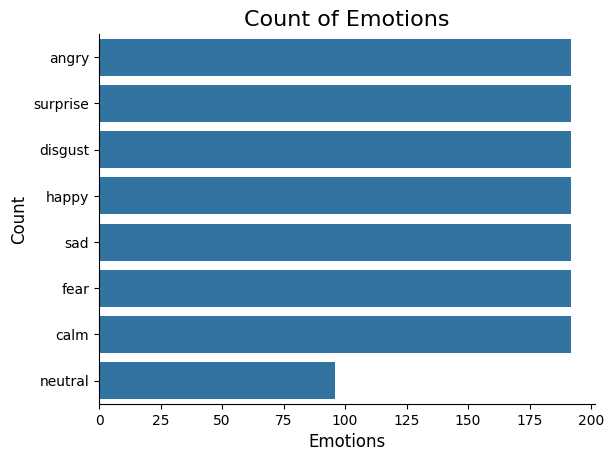

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [12]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [13]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

03-01-06-02-01-01-08.wav


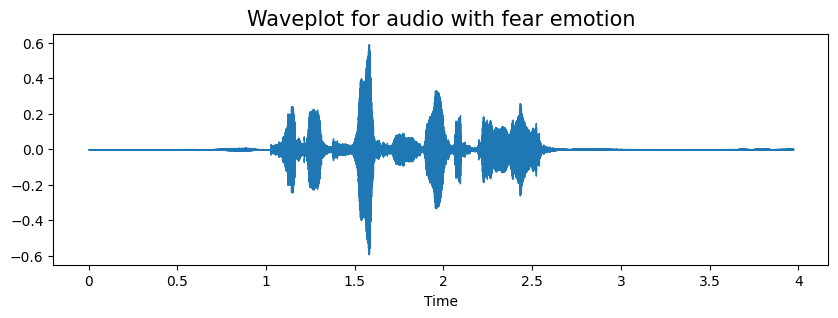

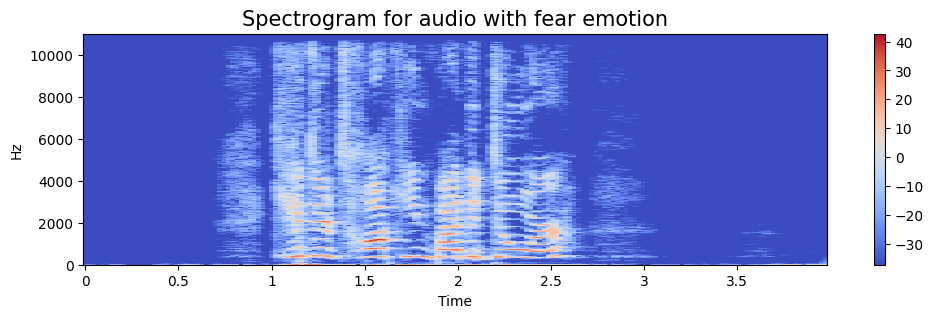

In [14]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

03-01-05-01-02-02-08.wav


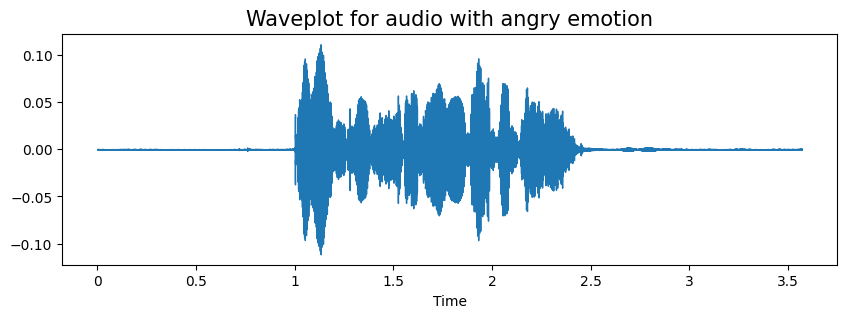

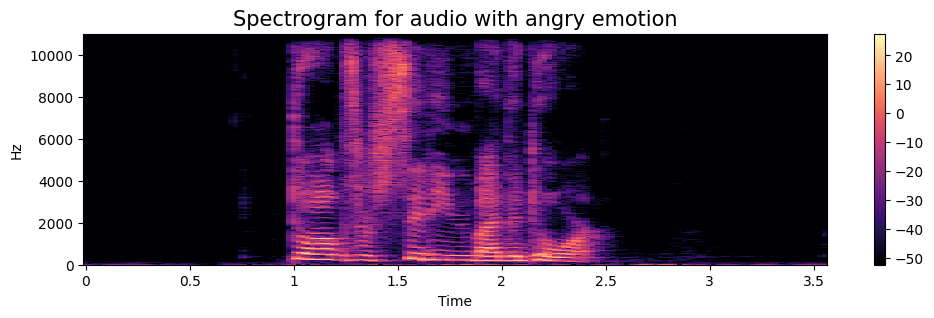

In [15]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

03-01-04-01-01-01-08.wav


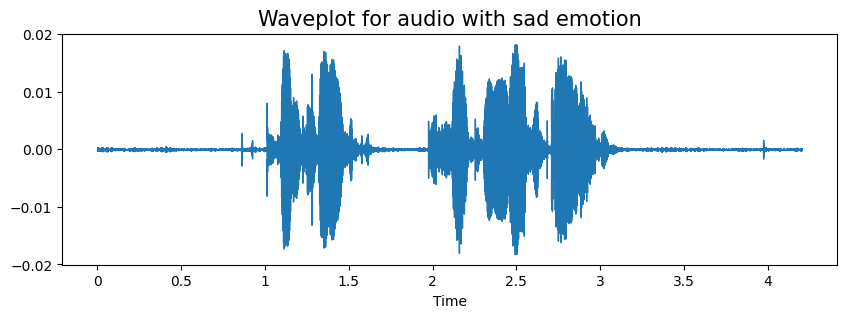

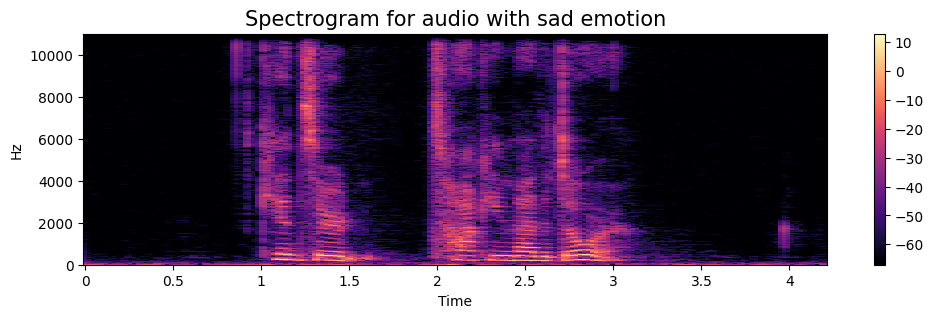

In [16]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

03-01-03-01-02-02-09.wav


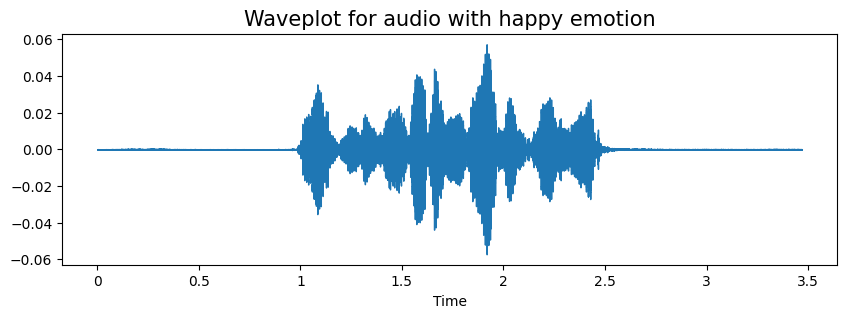

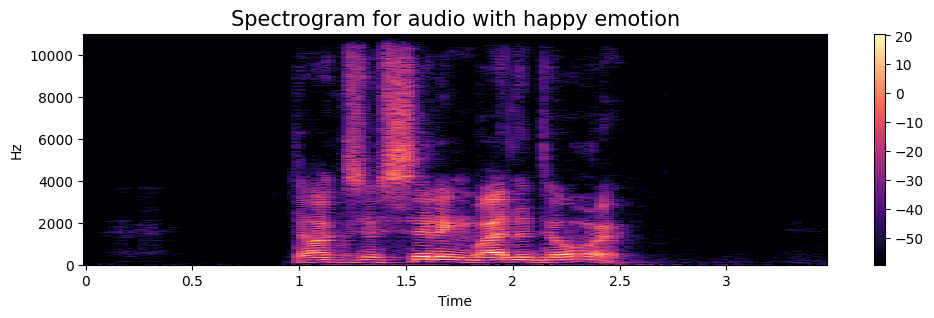

In [17]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [18]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate=0.3, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=0.5, n_steps=4)

# taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

##Simple audio

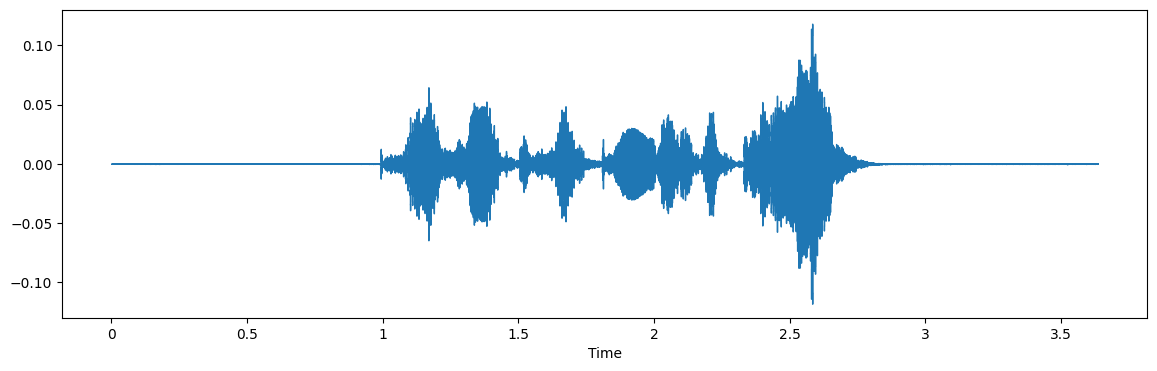

In [19]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

##Noise injection

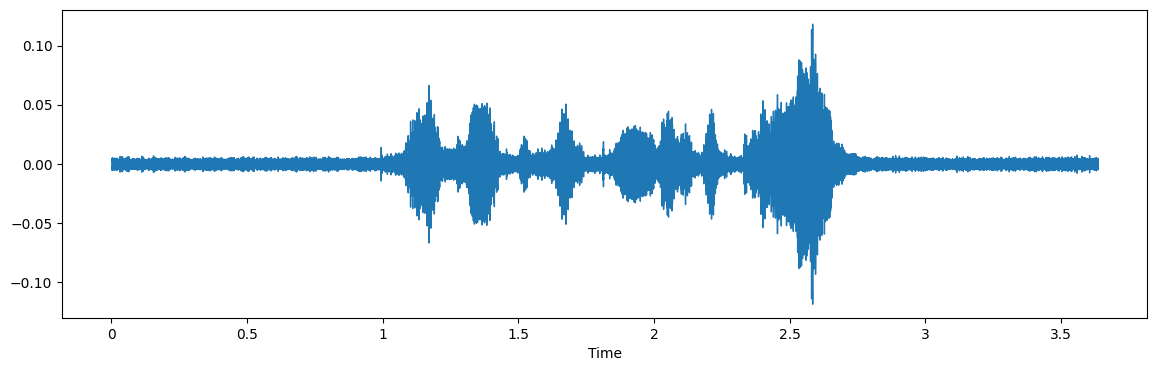

In [20]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

##Stretching

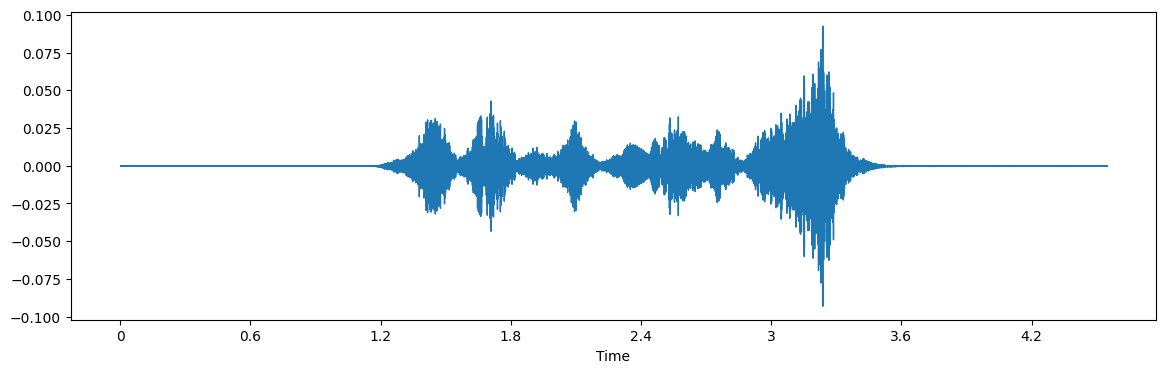

In [21]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

##Shifting

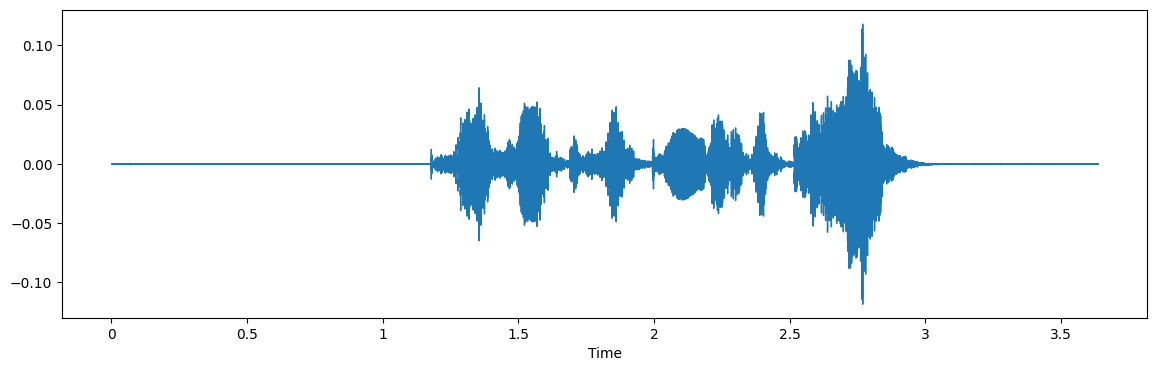

In [22]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

##Pitch

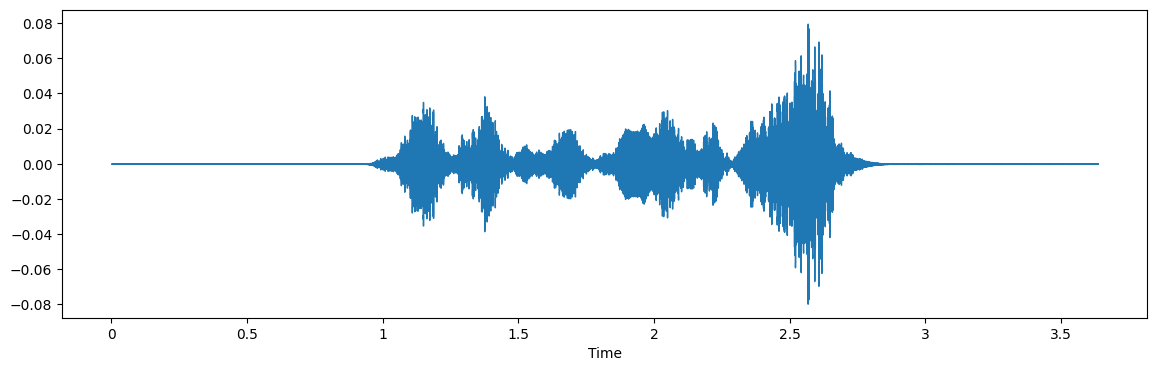

In [23]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

##Feature Extraction

In [24]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [25]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [26]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [28]:
len(X), len(Y), Ravdess_df.Path.shape

(4320, 4320, (1440,))

In [30]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features

0         1         2         3         4         5         6  \
0     0.136778  0.612642  0.576470  0.622328  0.632511  0.591668  0.591581   
1     0.208790  0.640600  0.664668  0.631305  0.678394  0.666928  0.636325   
2     0.153194  0.568586  0.491040  0.541515  0.569745  0.559350  0.511501   
3     0.215273  0.702988  0.678525  0.616126  0.693839  0.695504  0.584309   
4     0.265607  0.754207  0.738564  0.711286  0.764186  0.771953  0.639872   
...        ...       ...       ...       ...       ...       ...       ...   
4315  0.317482  0.724384  0.713557  0.722505  0.772548  0.739672  0.679465   
4316  0.116073  0.688858  0.570035  0.545757  0.595676  0.554735  0.490634   
4317  0.203166  0.718604  0.698123  0.635732  0.665414  0.650696  0.605490   
4318  0.290984  0.751140  0.740068  0.707923  0.733489  0.731553  0.670842   
4319  0.145739  0.530823  0.596087  0.690297  0.702570  0.710287  0.636939   

             7         8         9  ...       153       154       155  \
0     0.601421  0.595243  0.541838  ...  0.005098  0.004042  0.009158   
1     0.587173  0.612194  0.588099  ...  0.005100  0.004043  0.009156   
2     0.541827  0.599814  0.572188  ...  0.000706  0.000728  0.000343   
3     0.543327  0.603465  0.660531  ...  0.000194  0.000240  0.000265   
4     0.597401  0.659889  0.708941  ...  0.000345  0.000409  0.000447   
...        ...       ...       ...  ...       ...       ...       ...   
4315  0.612755  0.678132  0.724795  ...  0.002491  0.003261  0.003475   
4316  0.468332  0.575056  0.520119  ...  0.000023  0.000018  0.000019   
4317  0.577046  0.556778  0.564170  ...  0.001824  0.002736  0.003706   
4318  0.621188  0.590113  0.590353  ...  0.002235  0.003182  0.004124   
4319  0.542161  0.581489  0.640446  ...  0.000435  0.000311  0.000171   

           156       157       158       159       160           161    labels  
0     0.009979  0.010435  0.010085  0.006492  0.003016  3.125535e-04     angry  
1     0.009977  0.010435  0.010081  0.006493  0.003015  3.157424e-04     angry  
2     0.000274  0.000340  0.000404  0.000252  0.000245  2.263861e-05     angry  
3     0.000269  0.000249  0.000224  0.000239  0.000134  1.029136e-05  surprise  
4     0.000444  0.000423  0.000388  0.000397  0.000298  1.795908e-04  surprise  
...        ...       ...       ...       ...       ...           ...       ...  
4315  0.004254  0.005795  0.004167  0.006925  0.006976  2.617108e-03     angry  
4316  0.000013  0.000016  0.000017  0.000021  0.000014  6.318962e-07     angry  
4317  0.004278  0.003517  0.002963  0.003158  0.001764  1.347639e-04  surprise  
4318  0.004781  0.003942  0.003401  0.003634  0.002292  6.238616e-04  surprise  
4319  0.000133  0.000200  0.000373  0.000385  0.000279  1.551434e-05  surprise  

[4320 rows x 163 columns]

##Preprocessing

In [86]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [88]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [89]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [103]:
model = Sequential()

In [104]:
model.add(Conv1D(256, kernel_size=10, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=8, activation='softmax'))

In [105]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_46 (Conv1D)          (None, 162, 256)          2816      
                                                                 
 conv1d_47 (Conv1D)          (None, 162, 128)          163968    
                                                                 
 dropout_14 (Dropout)        (None, 162, 128)          0         
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 81, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_48 (Conv1D)          (None, 81, 128)           82048     
                                                                 
 conv1d_49 (Conv1D)          (None, 81, 128)           82048     
                                                      

In [106]:
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [107]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 31s 572ms/step - loss: 1.9090 - accuracy: 0.2327 - val_loss: 1.7350 - val_accuracy: 0.3130 - lr: 0.0010
Epoch 2/50
51/51 [==============================] - 31s 605ms/step - loss: 1.7013 - accuracy: 0.3444 - val_loss: 1.6350 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 3/50
51/51 [==============================] - 29s 567ms/step - loss: 1.5884 - accuracy: 0.4059 - val_loss: 1.5714 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 4/50
51/51 [==============================] - 29s 564ms/step - loss: 1.5194 - accuracy: 0.4306 - val_loss: 1.5032 - val_accuracy: 0.4463 - lr: 0.0010
Epoch 5/50
51/51 [==============================] - 31s 601ms/step - loss: 1.4087 - accuracy: 0.4750 - val_loss: 1.4616 - val_accuracy: 0.4602 - lr: 0.0010
Epoch 6/50
51/51 [==============================] - 31s 612ms/step - loss: 1.3717 - accuracy: 0.4910 - val_loss: 1.4327 - val_accuracy: 0.4528 - lr: 0.0010
Epoch 7/50
51/51 [==============================] - 29s 576ms/st

In [110]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 29s 580ms/step - loss: 0.0344 - accuracy: 0.9880 - val_loss: 2.1636 - val_accuracy: 0.6556 - lr: 1.0000e-07
Epoch 2/50
51/51 [==============================] - 30s 584ms/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 2.1638 - val_accuracy: 0.6556 - lr: 1.0000e-07
Epoch 3/50
51/51 [==============================] - 30s 580ms/step - loss: 0.0356 - accuracy: 0.9870 - val_loss: 2.1638 - val_accuracy: 0.6556 - lr: 1.0000e-07
Epoch 4/50
51/51 [==============================] - 29s 579ms/step - loss: 0.0464 - accuracy: 0.9858 - val_loss: 2.1638 - val_accuracy: 0.6556 - lr: 1.0000e-07
Epoch 5/50
51/51 [==============================] - 29s 576ms/step - loss: 0.0356 - accuracy: 0.9892 - val_loss: 2.1638 - val_accuracy: 0.6556 - lr: 1.0000e-07
Epoch 6/50
51/51 [==============================] - 29s 572ms/step - loss: 0.0356 - accuracy: 0.9889 - val_loss: 2.1639 - val_accuracy: 0.6556 - lr: 1.0000e-07
Epoch 7/50
51/51 [======================

34/34 [==============================] - 5s 144ms/step - loss: 2.1650 - accuracy: 0.6574
Accuracy of our model on test data :  65.74074029922485 %


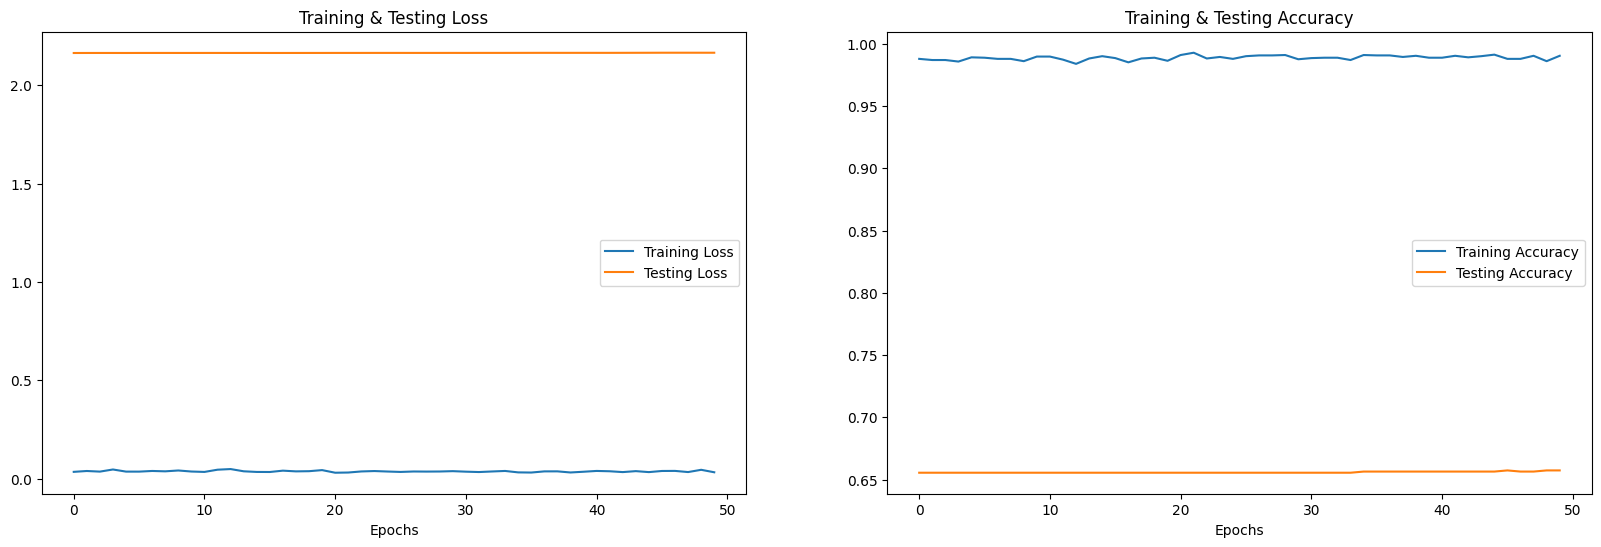

In [111]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [112]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 [==============================] - 5s 148ms/step


In [113]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear      surprise
1         surprise      surprise
2          disgust       disgust
3             calm          calm
4            happy         happy
5              sad          calm
6             fear          fear
7         surprise      surprise
8         surprise      surprise
9             fear          fear

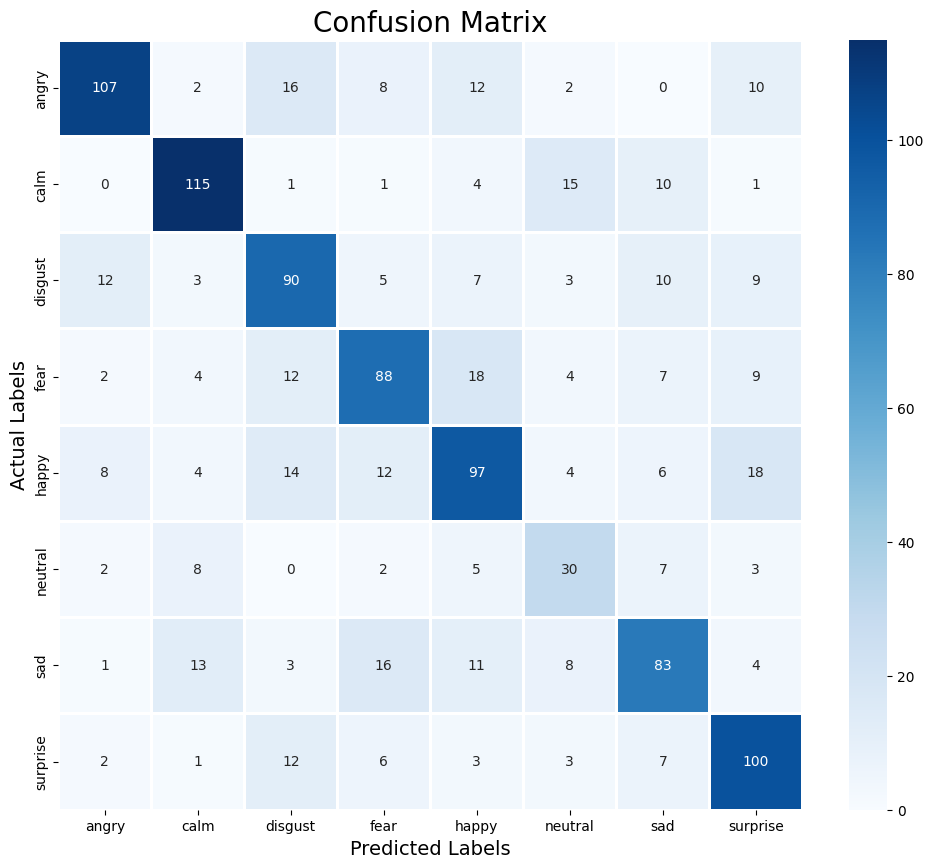

In [114]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.80      0.68      0.74       157
        calm       0.77      0.78      0.77       147
     disgust       0.61      0.65      0.63       139
        fear       0.64      0.61      0.62       144
       happy       0.62      0.60      0.61       163
     neutral       0.43      0.53      0.48        57
         sad       0.64      0.60      0.62       139
    surprise       0.65      0.75      0.69       134

    accuracy                           0.66      1080
   macro avg       0.64      0.65      0.64      1080
weighted avg       0.66      0.66      0.66      1080

